## Book Recommendations

1. Load the dataset and preparation
    a. clean duplicated data in each dataset
    b. cek baris yg kosong
2. EDA
    a. Distribusi user melakukan rating
3. Melakukan non personalized recommendations (top K)
4. Melakukan personalized recommendations based on genre (top K each genre)

## 1. Load the dataset and preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import BaselineOnly
from surprise.model_selection import train_test_split

In [2]:
ratings = pd.read_csv('data/ratings.csv')
books = pd.read_csv('data/books.csv')
to_read = pd.read_csv('data/to_read.csv')

In [3]:
ratings['user_id'] = ratings['user_id'].astype(str)
books[['book_id', 'goodreads_book_id', 'best_book_id', 'work_id']] = books[['book_id', 'goodreads_book_id', 'best_book_id', 'work_id']].astype(str)
to_read[['user_id', 'book_id']] = to_read[['user_id', 'book_id']].astype(str)

## a. clean duplicated data in each dataset

In [4]:
user_counts = pd.DataFrame(ratings['user_id'].value_counts())
user_counts.reset_index(drop = False, inplace=True)
user_counts.columns = ['user_id', 'rated_books']
user_counts

,user_id,rated_books
0,12874,200
1,30944,200
2,52036,199
3,12381,199
4,28158,199
...,...,...
53419,32128,21
53420,40753,21
53421,51725,21
53422,43675,20


Text(0, 0.5, 'Users Count')

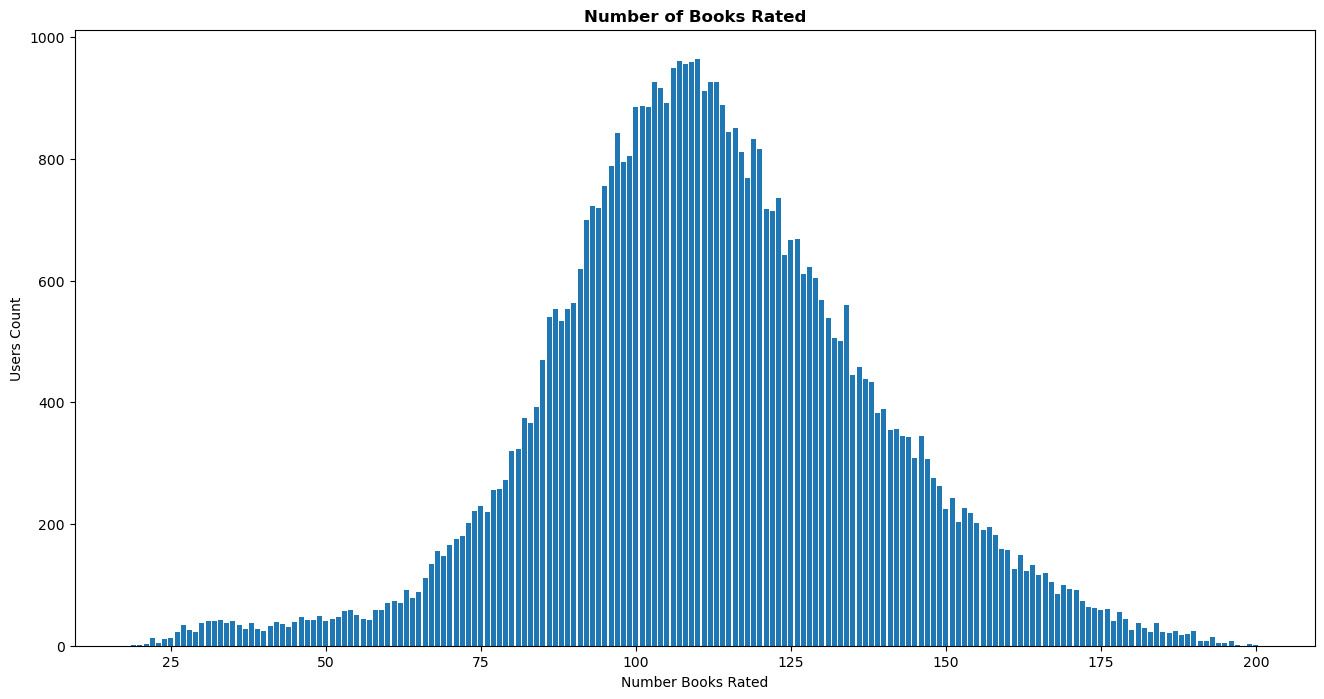

In [5]:
user_counts_v2 = pd.DataFrame(user_counts['rated_books'].value_counts()).reset_index(drop = False)
user_counts_v2.columns = ['rated_books','user_counts']
user_counts_v2.sort_values(by = 'rated_books', inplace=True)
user_counts_v2.reset_index(drop = True, inplace= True)
plt.figure(figsize=(16,8))
plt.title("Number of Books Rated", weight='bold')
plt.bar(x=user_counts_v2.rated_books,height='user_counts', data=user_counts_v2)
plt.xlabel("Number Books Rated")
plt.ylabel("Users Count")

In [6]:
# create personalized by genre
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [7]:
books.drop_duplicates(inplace = True)
ratings.drop_duplicates(inplace = True)
ratings.head(1)

,user_id,book_id,rating
0,1,258,5


## 2. Personalized

In [8]:
import copy

In [9]:
# create utility data
# Initiate rating scale
reader = Reader(rating_scale = (1, 5))
# Data Preparation
utility_data = Dataset.load_from_df(
                    df = ratings[['user_id', 'book_id', 'rating']].copy(),
                    reader = reader
                )
utility_data


In [12]:
utility_data.df.shape

(5976479, 3)

In [13]:
# Split Train Test
# Create a function
def train_test_split(utility_data, test_size, random_state):
    """
    Train test split the data
    ref: https://surprise.readthedocs.io/en/stable/FAQ.html#split-data-for-unbiased-estimation-py

    Parameters
    ----------
    utility_data : Surprise utility data
        The sample of whole data set

    test_size : float, default=0.2
        The test size

    random_state : int, default=42
        For reproducibility

    Returns
    -------
    full_data : Surprise utility data
        The new utility data

    train_data : Surprise format
        The train data

    test_data : Surprise format
        The test data
    """
    # Deep copy the utility_data
    full_data = copy.deepcopy(utility_data)

    # Generate random seed
    np.random.seed(random_state)

    # Shuffle the raw_ratings for reproducibility
    raw_ratings = full_data.raw_ratings
    np.random.shuffle(raw_ratings)

    # Define the threshold
    threshold = int((1-test_size) * len(raw_ratings))

    # Split the data
    train_raw_ratings = raw_ratings[:threshold]
    test_raw_ratings = raw_ratings[threshold:]

    # Get the data
    full_data.raw_ratings = train_raw_ratings
    train_data = full_data.build_full_trainset()
    test_data = full_data.construct_testset(test_raw_ratings)

    return full_data, train_data, test_data


In [14]:
full_data, train_data, test_data = train_test_split(utility_data,
                                                    test_size = 0.2,
                                                    random_state = 42)

## Modelling using Baseline and Funk SVD

In [15]:
from surprise.model_selection.search import RandomizedSearchCV
from surprise import AlgoBase, SVD
from surprise.model_selection import cross_validate

### a. Baseline

In [16]:
class MeanPrediction(AlgoBase):
    '''Baseline prediction. Return global mean as prediction'''
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        '''Fit the train data'''
        AlgoBase.fit(self, trainset)

    def estimate(self, u, i):
        '''Perform the estimation/prediction.'''
        est = self.trainset.global_mean
        return est

In [17]:
model_baseline = MeanPrediction()
model_baseline

In [18]:
cv_baseline = cross_validate(algo = model_baseline,
                             data = full_data,
                             cv = 3,
                             measures = ['rmse'])

cv_baseline_rmse = cv_baseline['test_rmse'].mean()
cv_baseline_rmse

: 

: 

### b. Funk SVD

In [17]:
#create dictionary of parameter
params_SVD = {'lr_all' : [1,0.1,0.01,0.001,0.0001], 'n_factors' : [50,100,200],
              'reg_all' : [1,0.1,0.01,0.02]
              } 

In [18]:
tuning_svd = RandomizedSearchCV(algo_class=SVD, param_distributions = params_SVD,
                   cv=5
                   )

tuning_svd.fit(data=full_data)

: 

: 

### c. KNN